# Предсказание автомобиля марки Ford по VIN-коду с применением регулярных выражений

VIN-код или Идентификационный номер транспортного средства - это уникальный код транспортного средства, состоящий из 17 знаков. В коде представлены сведения о производителе и характеристиках транспортного средства, а также о годе выпуска. Строение кода основано на стандартах ISO 3779-1983 и ISO 3780.Расшифровка каждой позиции, а также применяемые в данной работе обозначения приведены в Таблице 1.

<p style="text-align: center;">Северо-американские VIN-коды (Таблица 1)</p>

|Позиции|Описание|Обозначение в проекте|
|-|--------|---------|
|1,2,3|Всемирный индекс изготовителя|WMI|
|4|Тормозная система, Масса, Подушка безопасности|RESTRAINT|
|5,6,7|Линия транспортных средств, Серия и Тип кузова|MODEL|
|8|Код двигателя|ENGINE|
|9|Контрольная цифра|CHECK|
|10|Год выпуска|YEAR|
|11|Завод-изготовитель|PLANT|
|12-17|Порядковый номер|VIS|

На входе имеем текстовый файл с довольно «грязными» данными, содержащие только VIN-коды автомобилей марки FORD и стоимость этих автомобилей. Так же в файле присутствует лишний текст на русском языке. 

**Задача**: На основе этих данных необходимо построить модель предсказывающую стоимость автомобилей. 

Поставленная задача предполагает предсказание цены, а это непрерывная переменная, поэтому в данной работе будем решать задачу регрессии. Наиболее распространенным способом измерения точности регрессионной модели является вычисление среднеквадратичной ошибки (RMSE), метрики, которая сообщает нам, насколько в среднем наши прогнозируемые значения отличаются от наших наблюдаемых значений в модели. Так же в данной работе для измерения точности прогнозирования модели будем оценивать среднюю абсолютную ошибку (MAPE) в процентах.

Сформулируем **план** решения данной задачи.

1. С помощью регулярных выражений установить правила, для определения допустимых символов и цифр в VIN-коде
2. С помощью регулярных выражений установить правила разделения VIN-кода в соответствии с позициями и их расшифровкой VIN-кода, приведенных в таблице 1.
3. С помощью регулярных выражений провести поиск невалидных объектов в имеющихся данных и в случае наличия, удалить их
4. Сформировать рабочий датафрейм, провести предобработку и исследовательский анализ данных.
5. Подготовить данные для обучение модели (разделение на тренировочную и тестовую выборку).
6. Подобрать оптимальную модель для обучения. Оптимальность модели будем оценивать с помощью метрик RMSE и MAPE.
7. Оценить адекватность модели с помощью константной модели.
8. Оценить важность признаков.
9. Сформулировать выводы.

In [1]:
import re

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import xgboost
from xgboost import XGBRegressor

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import make_scorer, mean_absolute_percentage_error, mean_squared_error

import shap

### 1. Определение правил, для определения допустимых символов и цифр в VIN-коде

In [2]:
ALLOWED_CHARS = [chr(x) for x in range(ord('A'), ord('Z')+1) if chr(x) not in ('I', 'O', 'Q')]
ALLOWED_NUMS = [str(x) for x in range(1,10)] + ['0']

allowed = ''.join(ALLOWED_CHARS+ALLOWED_NUMS)
allowed

'ABCDEFGHJKLMNPRSTUVWXYZ1234567890'

### 2. Определение правил разделения VIN-кода в соответствии с позициями и их расшифровкой, приведенных в таблице 1

In [3]:
wmi = f'(?P<wmi>[{allowed}]{{3}})'             #позиции 1, 2, 3 (Таблица 1)
restraint = f'(?P<restraint>[{allowed}])'      #позиция 4 (Таблица 1)
model = f'(?P<model>[{allowed}]{{3}})'         #позиции 5, 6, 7 (Таблица 1)
engine = f'(?P<engine>[{allowed}])'            #позиция 8 (Таблица 1)
check = f'(?P<check>[{allowed}])'              #позиция 9 (Таблица 1)
year = f'(?P<year>[{allowed}])'                #позиция 10 (Таблица 1)
plant = f'(?P<plant>[{allowed}])'              #позиция 11 (Таблица 1)
vis = f'(?P<vis>[{allowed}]{{3}}\\d{{3}})'     #позиции 12 - 17 (Таблица 1)

VIN = f'{wmi}{restraint}{model}{engine}{check}{year}{plant}{vis}' #re-выражение для VIN-кода
PRICE = r'(?P<price>\d+)'                                         #re-выражение для цены

Откроем файл,представленный в виде текстового файла и выведем первые 250 значений

In [4]:
with open('vin_ford_train.txt', 'r', encoding='utf-8') as f:
    content = f.read()
    
content[:250] #первые 250 значений

'[2FMDK3JC4BBA41556:12500]мой[3FA6P0H75ER208976:14500]дядя [3FAHP08Z17R268380:1300][1FMCU0GX3DUC59421:15200]самых [1FAHP2E89DG119368:11600] верных[1FM5K8D82DGA16143:26400][1FTFW1CFXCFC23663:14000][2FMDK3JC6CBA90002:19500][1FTFW1CT8DKD06233:24400][1FMZ'

С помощью регулярных выражений приведем данные к формату **[VIN:PRICE]**

In [5]:
data = re.compile(f'\\[{VIN}:{PRICE}\\]')
data

re.compile(r'\[(?P<wmi>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{3})(?P<restraint>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])(?P<model>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{3})(?P<engine>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])(?P<check>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])(?P<year>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])(?P<plant>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])(?P<vis>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{3}\d{3}):(?P<price>\d+)\]',
           re.UNICODE)

Для того, чтобы в дальнейшем преобразовать данные в единый датафрейм сформируем словарь из обозначений (Таблица 1) и "вытащим" соответствующее ему значение

In [6]:
values = []
for obj in data.finditer(content):
    values.append(obj.groupdict())

values[:1]

[{'wmi': '2FM',
  'restraint': 'D',
  'model': 'K3J',
  'engine': 'C',
  'check': '4',
  'year': 'B',
  'plant': 'B',
  'vis': 'A41556',
  'price': '12500'}]

In [7]:
len(values)

71884

**Вывод по разделу:** Такии образом получили, что входные данные имеют 71884 VIN-кода для автомобилей марки FORD 

### 3. Проведение поиска невалидных объектов в имеющихся данных

In [8]:
valid_vin = r'(\w{14}\d{3})'               #валидный VIN-код
valid_price = r'(\d+)'                     #валидная цена

invalid_vin = r'(?!\w{14}\d{3})(\w+)'      #невалидный VIN-код
invalid_prcie = r'(?!\d+)(\w+)'            #невалидная цена

invalid_variance = [
    f'\\[{invalid_vin}:{invalid_prcie}\\]',    #все возможные варианты валидных и невалидных
    f'\\[{valid_vin}:{invalid_prcie}\\]',      #объектов
    f'\\[{invalid_vin}:{valid_price}\\]',
]

#определим невалидный паттерн
invalid_pattern = re.compile('(?P<invalid_data>' + '|'.join(invalid_variance) + ')')

#сформируем словарь всех невалидных объектов в формате [VIN-код:Цена]
invalid_values = []
for obj in invalid_pattern.finditer(content):
    invalid_values.append(obj.groupdict())
    
invalid_values

[{'invalid_data': '[1FM5K8D83DGB91002:XXXX]'},
 {'invalid_data': '[1FM5K8D83DGB9100X:26600]'}]

**Вывод по разделу:** Таким образом получили, что в имеющихся данных присутсвуют два невалидных VIN-кода:

- [1FM5K8D83DGB91002:XXXX] - так как вместо Цены имеем ХХХХ;
- [1FM5K8D83DGB9100X:26600] - так как в конце VIN-кода имеем не цифровое значение

### 4. Формирование датафрейма и проведение предобработки данных

In [9]:
data_ford = pd.DataFrame(values)

Напишем функцию для "чекинга" полученного датафрейма

In [10]:
def check(data):
    display(data.head(10))
    print('-----------------')
    display(data.info())
    print('-----------------')
    display(data.describe())
    print('-----------------')
    print('Количество явных дубликатов:', data.duplicated().sum())
    print('-----------------')
    display(data.isna().sum())

Посмотрим на полученный датафрейм

In [11]:
check(data_ford)

,wmi,restraint,model,engine,check,year,plant,vis,price
0,2FM,D,K3J,C,4,B,B,A41556,12500
1,3FA,6,P0H,7,5,E,R,208976,14500
2,3FA,H,P08,Z,1,7,R,268380,1300
3,1FM,C,U0G,X,3,D,U,C59421,15200
4,1FA,H,P2E,8,9,D,G,119368,11600
5,1FM,5,K8D,8,2,D,G,A16143,26400
6,1FT,F,W1C,F,X,C,F,C23663,14000
7,2FM,D,K3J,C,6,C,B,A90002,19500
8,1FT,F,W1C,T,8,D,K,D06233,24400
9,1FM,Z,U64,W,1,3,U,C28949,2900


-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   wmi        71884 non-null  object
 1   restraint  71884 non-null  object
 2   model      71884 non-null  object
 3   engine     71884 non-null  object
 4   check      71884 non-null  object
 5   year       71884 non-null  object
 6   plant      71884 non-null  object
 7   vis        71884 non-null  object
 8   price      71884 non-null  object
dtypes: object(9)
memory usage: 4.9+ MB


None

-----------------


,wmi,restraint,model,engine,check,year,plant,vis,price
count,71884,71884,71884,71884,71884,71884,71884,71884,71884
unique,14,26,365,32,11,25,21,68215,643
top,1FM,D,P0H,2,1,D,R,B55197,11000
freq,18347,12370,6171,7015,6622,17286,10535,4,574


-----------------
Количество явных дубликатов: 0
-----------------


wmi          0
restraint    0
model        0
engine       0
check        0
year         0
plant        0
vis          0
price        0
dtype: int64

Получили датафрейм размерностью 71884 на 9 (столбцы определены в соответствии с обозначениями, приведенными в Таблице 1). Пропуски и дубликаты в данных не обнаружены

In [12]:
data_ford['price'] = data_ford['price'].astype(int) #приведем Цену к числовому типу данных

In [13]:
data_ford.describe() #посмотрим на описательные характеристики

,price
count,71884.000000
mean,14321.449377
std,7827.057238
min,1000.000000
25%,8800.000000
50%,13500.000000
75%,19500.000000
max,36500.000000


Получили, что цена автомобилей FORD лежит в диапазоне от 1000 до 36500, среднее значение цены составляет 14321,5, а медианное 13500. Далее посмотрим на распределение цены с помощью построения гистограммы, а также для определения возможных выбросов построим "ящик с усами".

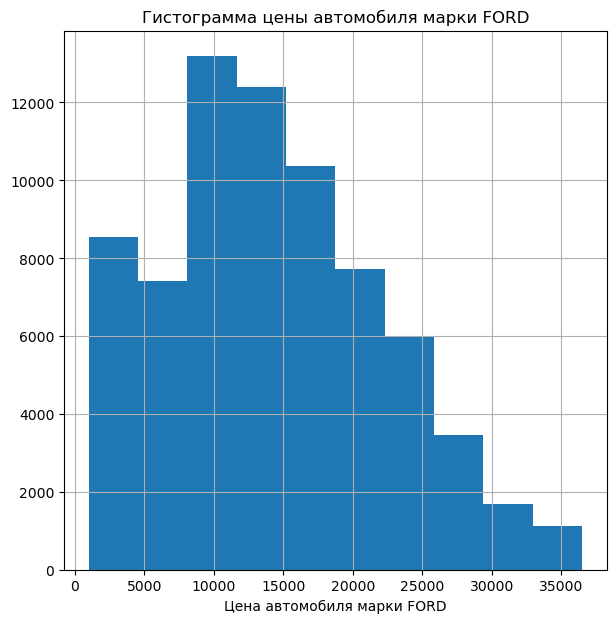

In [14]:
data_ford['price'].hist(figsize=(7,7))
plt.xlabel('Цена автомобиля марки FORD')
plt.title('Гистограмма цены автомобиля марки FORD')
plt.show()

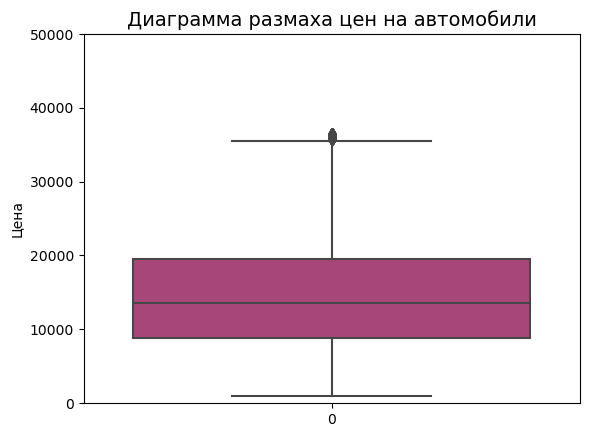

In [15]:
sns.boxplot(data=data_ford['price'], palette='magma', width=0.8)
plt.title('Диаграмма размаха цен на автомобили', fontsize=14)
#plt.xlabel('Время мощности')
plt.ylabel('Цена')
plt.ylim(0, 50000)
plt.show()

**Вывод по разделу**

На основе имеющих данных сформировали датафрейм размерностью 718884 на 9. Для минимального исследовательского анализа цены провели преобразование цены к числовому виду и построли гистограмму и диаграмму размаха ("ящик с усами").
По полученым графикам видно, что цена имеет близкое к нормальному распределение, и не имеет аномальных выбросов в виде очень маленьких либо очень больших цен на автомобили.


### 5. Подготовка данных для обучения модели (разделение на тренировочную и тестовую выборку).

Разделим данные на признаки и целевой признак. Так же из признаков уберем контрольные цифры (CHECK) и порядковые номера (VIC), так как данные признаки не будут вносить особого влияния на предсказание моделей

In [16]:
features = data_ford.drop(['check', 'vis', 'price'], axis=1).astype('category')
target = data_ford['price']

In [17]:
print(features.shape, target.shape) #посмотрим на размерность

(71884, 6) (71884,)


Разделим данные на тренировочную и тестовые выборки в соотношении 3:1

In [18]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.25,
                                                                            random_state=12345)

In [19]:
#посмотрим на размерность тренировочной и тестовой выборок
print(features_train.shape, target_train.shape, features_test.shape, target_test.shape) 

(53913, 6) (53913,) (17971, 6) (17971,)


### 6. Определение оптимальной модели XGBRegressor

Так как в качестве признаков выступают категориальные признаки в качестве модели выбрана модель XGBRegressor

In [20]:
#Определение оцениваемых метрик RMSE и MAPE
scoring = ['neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error']

С помощью перебора параметров по GridSearchCV найдем оптимальные значения метрик RMSE и MAPE на тренировочной выборке

In [21]:
xgbr = XGBRegressor(enable_categorical=True) 
parameters = [{'n_estimators':[100, 200], 'random_state':[12345], 'max_depth':[5,6,7]}]

gscv = GridSearchCV(xgbr, parameters, scoring=scoring,
                    cv=2, n_jobs=5, refit='neg_root_mean_squared_error', return_train_score=True)
gscv.fit(features_train, target_train)


print("Наилучшие параметры модели на тренировочной выборке:")
print(gscv.best_params_)
print("Наилучшее значение RMSE на тренировочной выборке:")
print(-gscv.best_score_)
print("Наилучшее значение MAPE на тренировочной выборке:")
print(-gscv.cv_results_['mean_test_neg_mean_absolute_percentage_error'][gscv.best_index_])

Наилучшие параметры модели на тренировочной выборке:
{'max_depth': 5, 'n_estimators': 100, 'random_state': 12345}
Наилучшее значение RMSE на тренировочной выборке:
2813.8850043417206
Наилучшее значение MAPE на тренировочной выборке:
0.20428753608665762


In [22]:
xgbr_test = XGBRegressor(enable_categorical=True,
                          n_estimators=100,
                          max_depth=5,
                          random_state=12345) 
xgbr_test.fit(features_train, target_train)
prediction_test = xgbr_test.predict(features_test)
rsme_test = mean_squared_error(prediction_test, target_test) ** .5
mape_test = mean_absolute_percentage_error(prediction_test, target_test)
print('RMSE для модели XGBRegressor на тестовой выборке:', rsme_test)
print('MAPE для модели XGBRegressor на тестовой выборке:', mape_test)


RMSE для модели XGBRegressor на тестовой выборке: 2762.2998970014823
MAPE для модели XGBRegressor на тестовой выборке: 0.16894731206957606


**Вывод по разделу**:
1. Обучили модель XGBRegressor и перебором параметров определили оптимальную модель с наилучшими метриками RMSE и MAPE. Лучшая модель на тренировочной выборке с параметрами `n_estimators=100` и `max_depth=5` имеет значения RMSE=2813.88 и MAPE=0.20
2. Провели проверку оптимальной модели на тестовой выборке. Получили следующие значения метрик: RMSE=2762.29 и MAPE=0.17

### 7. Оценка адекватности модели с помощью константной модели

In [23]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(features_train, target_train)
dummy_predict = dummy.predict(features_test)
rmse_dummy = mean_squared_error(dummy_predict, target_test) ** .5
mape_dummy = mean_absolute_percentage_error(dummy_predict, target_test)
print('RMSE константной модели на тестовой выборке:', rmse_dummy)
print('MAPE константной модели на тестовой выборке:', mape_dummy)

RMSE константной модели на тестовой выборке: 7777.201738147304
MAPE константной модели на тестовой выборке: 0.4419440260420348


**Вывод по разделу**:
Оценку адекватности модели проводила с помощью простейшей Dummy модели, которая всегда предсказывает наиболее часто встречающийся класс. На данной модели получили следующие метрики:
RMSE=7777.20 и MAPE=0.44, которые гораздо больше полученных при обучении XGBRegressor, что доказывает адекватность ее построения и выбора

### 8. Оценка важности признаков

Оценку важности признаков построим с помощью библиотеки Seaborn

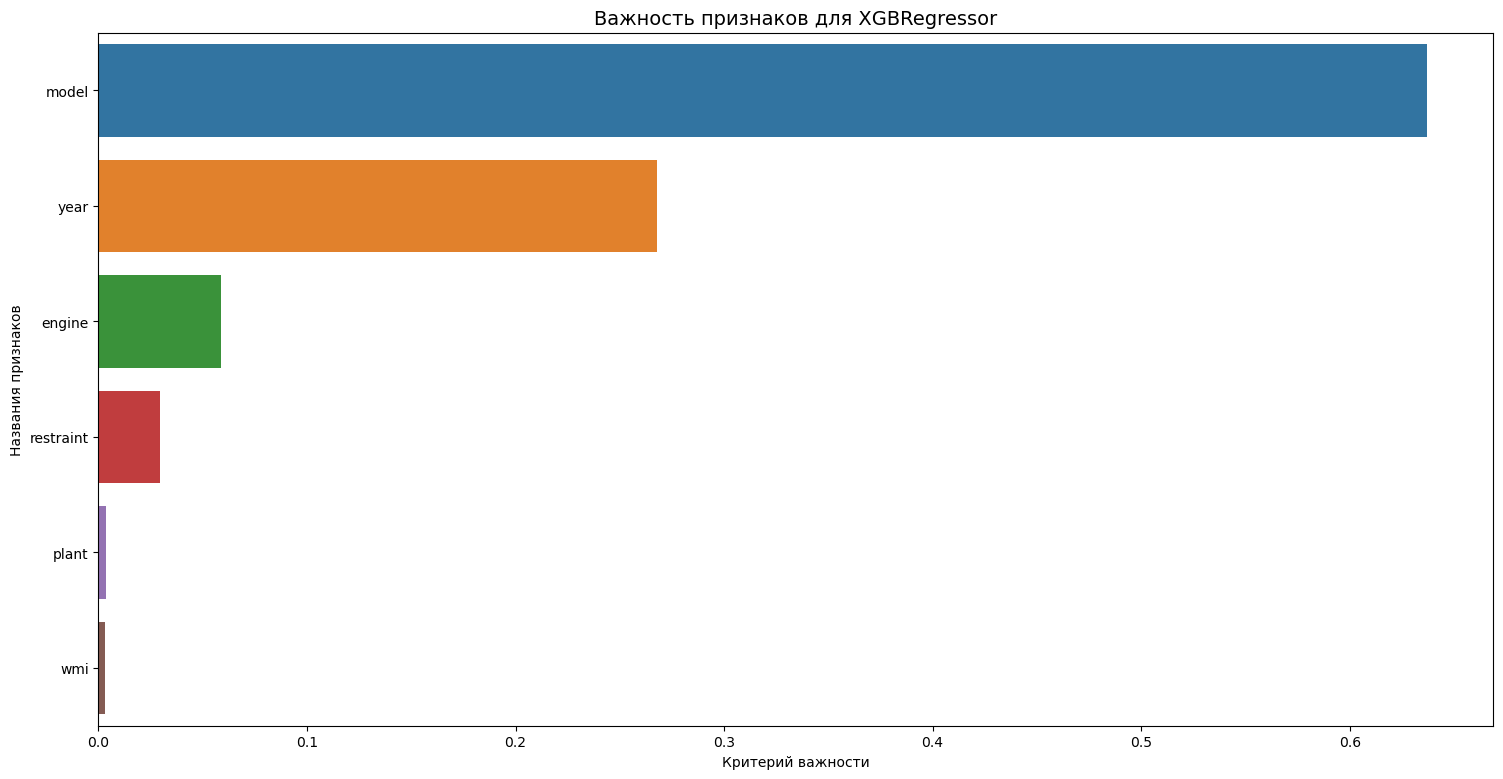

In [24]:
plot_data = {
    'features': features_test.columns,
    'feature_importances': xgbr_test.feature_importances_,
}
plot_data = pd.DataFrame(plot_data)
plot_data.sort_values(by='feature_importances', ascending=False, inplace=True)
plt.figure(figsize=(18, 9))
sns.barplot(x=plot_data['feature_importances'], y=plot_data['features'])
plt.title('Важность признаков для XGBRegressor', fontsize=14)
plt.xlabel('Критерий важности')
plt.ylabel('Названия признаков')
plt.show()

**Вывод по разделу**:
По полученной диаграмме важности признаков видно, что наибольшее влияние на цену оказывает модель и год выпуска автомобиля, дальше идут тип двигателя, тормозная система и т.д.

### 9. Общий вывод

Задачей данного исследования было предсказание цены автомобиля имея только текстовый файл с VIN-кодами автомобилей марки FORD с указанием их цены.

Для решения поставленной задачи были выполнены следующие действия:
1. С помощью регулярных выражений установлены правила, для определения допустимых символов и цифр в VIN-коде
2. С помощью регулярных выражений установлены правила разделения VIN-кода в соответствии с позициями и их расшифровкой VIN-кода, приведенных в таблице 1.
3. С помощью регулярных выражений провден поиск невалидных объектов в имеющихся данных
4. Сформирован рабочий датафрейм размерностью 71884 строк на 8 столбцов признаков плюс 1 столбец целевого признака - цены. Проведен исследовательский анализ целевого признака (построены гистограмма и диаграмма размаха). Установлено, что целевой признак распределен близко к нормальному, выбросы не обнаружены. Пропусков и явных дубликатов в данных тоже нет.
5. Подготовлены данные для обучение модели (разделение на тренировочную и тестовую выборку в соотношении 3:1). Получили выборки размерностью:
   - тренировочная  53913, 6;
   - тестовая 17971, 6 
6. Подобрана оптимальная модель для обучения. Оптимальность модели оценивалась с помощью метрик RMSE и MAPE. 
   - Обучили модель XGBRegressor и перебором параметров определили оптимальную модель с наилучшими метриками RMSE и MAPE. Лучшая модель на тренировочной выборке с параметрами `n_estimators=100` и `max_depth=5` имеет значения RMSE=2813.88 и MAPE=0.20
   - Провели проверку оптимальной модели на тестовой выборке. Получили следующие значения метрик: RMSE=2762.29 и MAPE=0.17
7. Адекватность модели оценивалась с помощью константной Dummy модели. На константной модели получили RMSE=7777.20 и MAPE=0.44, которые гораздо больше полученных при обучении XGBRegressor, что доказывает адекватность ее построения и выбора.
8. Проведена оценка важности признаков, установлено, что наибольшее влияние на предсказание цены автомоболя оказывает модель и год выпуска автомобиля.
